In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:

df = pd.read_csv("system-5.csv") 
df.head()

,timestamp,load-1m,load-5m,load-15m,sys-mem-swap-total,sys-mem-swap-free,sys-mem-free,sys-mem-cache,sys-mem-buffered,sys-mem-available,...,sys-thermal,disk-io-time,disk-bytes-read,disk-bytes-written,disk-io-read,disk-io-write,cpu-iowait,cpu-system,cpu-user,server-up
0,0,1.39,0.68,0.36,34274799616,34274799616,25542410240,5798469632,793202688,32352124928,...,1.30,0.0012,0.0,34201.6,0.0,2.60,0.002,0.1310,0.1900,2
1,30,0.97,0.65,0.36,34274799616,34274799616,25540894720,5798526976,793202688,32350666752,...,0.05,0.0012,0.0,23756.8,0.0,2.80,0.003,0.0305,0.0325,2
2,60,0.66,0.60,0.35,34274799616,34274799616,25537130496,5798596608,793202688,32346976256,...,1.25,0.0014,0.0,38707.2,0.0,5.15,0.002,0.0705,0.0885,2
3,90,0.53,0.58,0.35,34274799616,34274799616,25528676352,5798727680,793202688,32338583552,...,1.25,0.0008,0.0,38297.6,0.0,6.60,0.002,0.0415,0.0565,2
4,120,0.32,0.52,0.34,34274799616,34274799616,25524518912,5798961152,793202688,32334729216,...,0.05,0.0020,0.0,78233.6,0.0,12.90,0.004,0.0610,0.1320,2


In [3]:
df.columns

Index(['timestamp', 'load-1m', 'load-5m', 'load-15m', 'sys-mem-swap-total',
       'sys-mem-swap-free', 'sys-mem-free', 'sys-mem-cache',
       'sys-mem-buffered', 'sys-mem-available', 'sys-mem-total',
       'sys-fork-rate', 'sys-interrupt-rate', 'sys-context-switch-rate',
       'sys-thermal', 'disk-io-time', 'disk-bytes-read', 'disk-bytes-written',
       'disk-io-read', 'disk-io-write', 'cpu-iowait', 'cpu-system', 'cpu-user',
       'server-up'],
      dtype='object')

In [4]:
df = df.sort_values('timestamp')

In [5]:
timestamp_col = df['timestamp']
features = df.drop(columns=['timestamp'])

In [6]:
scaler = MinMaxScaler()

In [7]:
features_scaled = scaler.fit_transform(features)

In [9]:
#Creating sequences

def create_sequences(X, time_steps=30):
    sequences = []
    for i in range(len(X) - time_steps):
        sequences.append(X[i:(i + time_steps)])
    return np.array(sequences)

TIME_STEPS = 30
X_seq = create_sequences(features_scaled, TIME_STEPS)

# Split train/test
train_size = int(X_seq.shape[0] * 0.7)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]

In [10]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

C:\Users\SEC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam', loss='mse')

In [12]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)

In [13]:
history = model.fit(
    X_train, X_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - loss: 0.0103 - val_loss: 0.0027
Epoch 2/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 60s 71ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 3/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 4/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 5/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 7/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 9/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 10/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 47s 55ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 11/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 12/30
851/851 ━━━━━━━━━━

In [14]:
#Reconstruction errors per feature
X_test_pred = model.predict(X_test)

810/810 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


In [15]:
errors_per_feature = np.mean((X_test_pred - X_test) ** 2, axis=1)

In [16]:
total_error = np.mean(errors_per_feature, axis=1)

In [17]:
global_threshold = np.mean(total_error) + 3 * np.std(total_error)

In [18]:
feature_thresholds = np.mean(errors_per_feature, axis=0) + 3 * np.std(errors_per_feature, axis=0)

In [19]:
anomalies = total_error > global_threshold

In [20]:
reason_list = []
for i, err_vector in enumerate(errors_per_feature):
    reasons = [features.columns[j] for j, e in enumerate(err_vector) if e > feature_thresholds[j]]
    reason_list.append(reasons if reasons else None)

In [21]:
results = pd.DataFrame({
    'timestamp': timestamp_col.iloc[TIME_STEPS + train_size:].values,
    'total_error': total_error,
    'is_anomaly': anomalies,
    'reason_features': reason_list
})

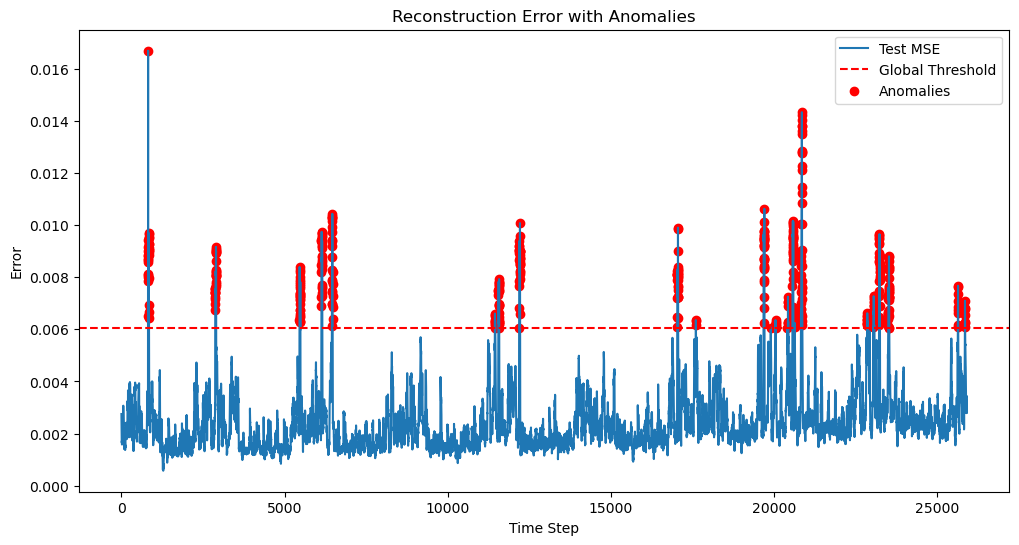

In [22]:
#Visualization 1: Error plot with anomalies
plt.figure(figsize=(12,6))
plt.plot(total_error, label='Test MSE')
plt.axhline(global_threshold, color='r', linestyle='--', label='Global Threshold')
plt.scatter(np.where(anomalies)[0], total_error[anomalies], color='red', label='Anomalies')
plt.title("Reconstruction Error with Anomalies")
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.legend()
plt.show()

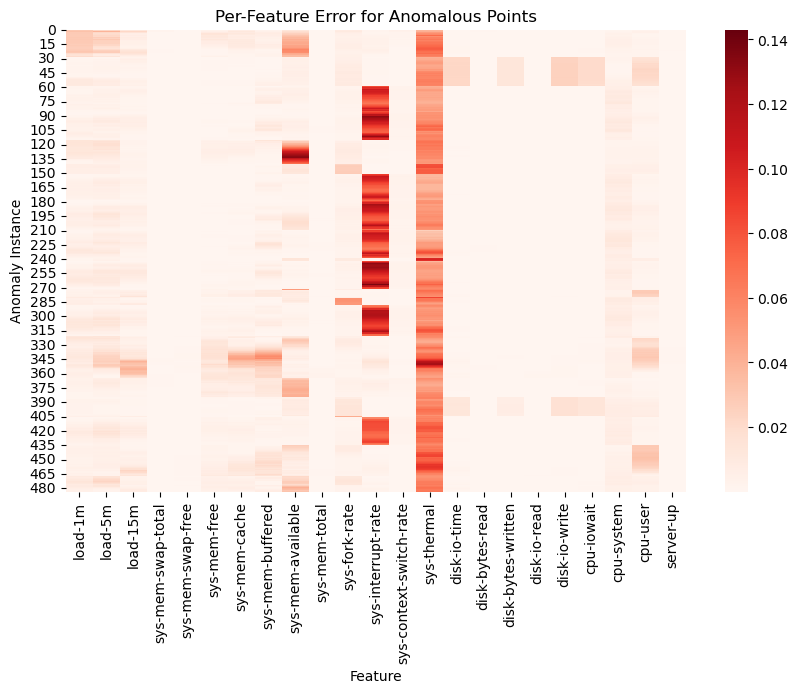

In [23]:
# Visualization 2: Heatmap of per-feature errors for anomalies

anom_idx = np.where(anomalies)[0]
if len(anom_idx) > 0:
    plt.figure(figsize=(10,6))
    sns.heatmap(errors_per_feature[anom_idx], cmap='Reds', xticklabels=features.columns)
    plt.title("Per-Feature Error for Anomalous Points")
    plt.xlabel("Feature")
    plt.ylabel("Anomaly Instance")
    plt.show()

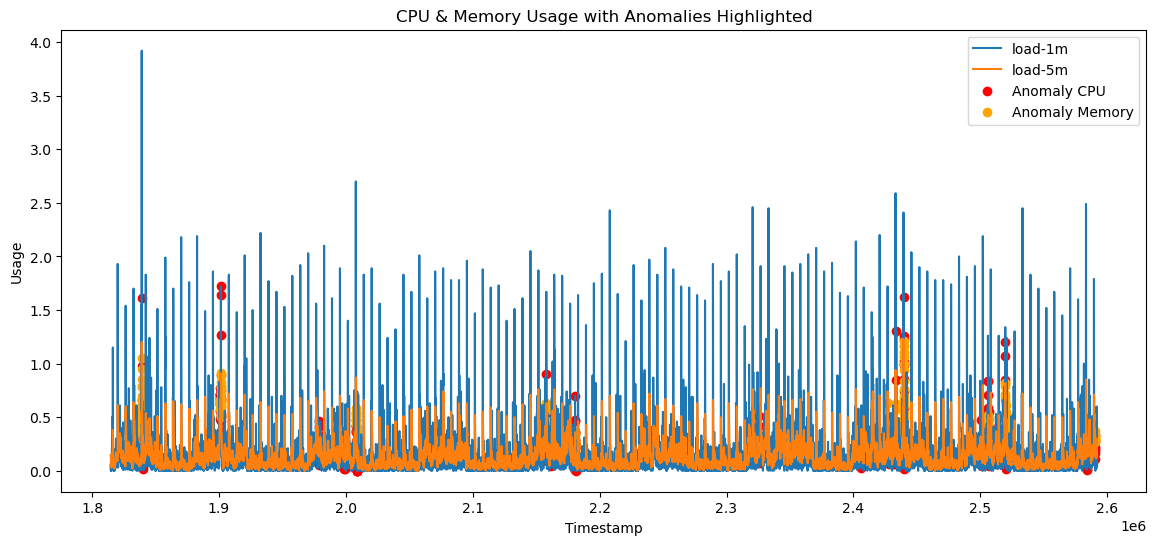

In [24]:

# Visualization 3: Original metric trends with anomaly highlights

test_timestamps = timestamp_col.iloc[TIME_STEPS + train_size:].values
original_test_data = features.iloc[TIME_STEPS + train_size:]

plt.figure(figsize=(14,6))
plt.plot(test_timestamps, original_test_data.iloc[:,0], label=features.columns[0])
plt.plot(test_timestamps, original_test_data.iloc[:,1], label=features.columns[1])
plt.scatter(test_timestamps[anomalies], original_test_data.iloc[:,0][anomalies], color='red', label='Anomaly CPU')
plt.scatter(test_timestamps[anomalies], original_test_data.iloc[:,1][anomalies], color='orange', label='Anomaly Memory')
plt.title("CPU & Memory Usage with Anomalies Highlighted")
plt.xlabel("Timestamp")
plt.ylabel("Usage")
plt.legend()
plt.show()

In [29]:
# Show anomaly report

print("\nAnomaly Report:")
print(results[results['is_anomaly']].head(20))


Anomaly Report:
     timestamp  total_error  is_anomaly  \
816    1839150     0.006513        True   
817    1839180     0.008645        True   
818    1839210     0.016683        True   
819    1839240     0.007852        True   
820    1839270     0.008074        True   
821    1839300     0.008017        True   
822    1839330     0.008682        True   
823    1839360     0.008112        True   
824    1839390     0.008853        True   
825    1839420     0.008588        True   
826    1839450     0.009433        True   
827    1839480     0.008819        True   
828    1839510     0.008998        True   
829    1839540     0.009166        True   
830    1839570     0.009273        True   
831    1839600     0.009117        True   
832    1839630     0.009290        True   
833    1839660     0.009032        True   
834    1839690     0.008982        True   
835    1839720     0.009060        True   

                                       reason_features  
816  [load-1m, load-5m